In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import os
from pathlib import Path

# Scikit-learn Utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score
from sklearn.neighbors import KNeighborsClassifier

# Konfigurasi Tampilan
%matplotlib inline
sns.set_style('whitegrid')

# --- 1. KONFIGURASI PATH ---
current_dir = Path(os.getcwd())
PROJECT_DIR = current_dir.parents[2]

INPUT_FILE = PROJECT_DIR / 'data' / 'processed' / 'features.csv'
MLRUNS_DIR = PROJECT_DIR / 'mlruns' 

# --- 2. SETUP MLFLOW ---
if not MLRUNS_DIR.exists():
    MLRUNS_DIR.mkdir(parents=True, exist_ok=True)

mlflow.set_tracking_uri(f"file:///{MLRUNS_DIR.as_posix()}")
# Nama eksperimen khusus KNN
mlflow.set_experiment("Roodio_Mood_KNN_Experiment")

# --- 3. LOAD DATA ---
if not INPUT_FILE.exists():
    raise FileNotFoundError(f"File features.csv tidak ditemukan di {INPUT_FILE}")

df = pd.read_csv(INPUT_FILE)
X = df.drop('label', axis=1)
y = df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(f"✅ Label Mapping: {label_mapping}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print("✅ Setup Selesai. Siap Training KNN.")

c:\Users\andiz\anaconda3\envs\roodio-env\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/01/22 13:33:15 INFO mlflow.tracking.fluent: Experiment with name 'Roodio_Mood_KNN_Experiment' does not exist. Creating a new experiment.


✅ Label Mapping: {0: 'angry', 1: 'happy', 2: 'relaxed', 3: 'sad'}
✅ Setup Selesai. Siap Training KNN.


🚀 Sedang Melatih KNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


2026/01/22 13:58:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Training Selesai!
🏆 Parameter Terbaik : {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}
📊 Akurasi Final     : 0.9281


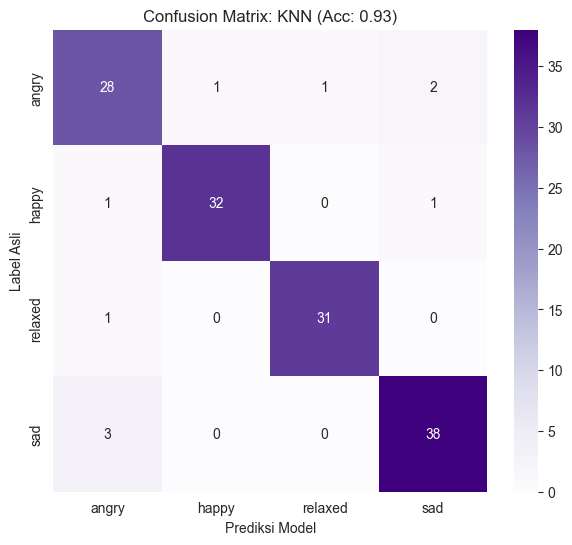

💾 Hasil KNN tersimpan lengkap di MLflow.


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

# --- 1. DEFINISI PIPELINE ---
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

# --- 2. GRID SEARCH PARAMETER ---
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# --- 3. EKSEKUSI TRAINING ---
run_name = "KNN_Tuning_Notebook"

with mlflow.start_run(run_name=run_name):
    print("🚀 Sedang Melatih KNN...")
    
    grid = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    
    # --- 4. EVALUASI ---
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_model.predict(X_test)
    
    test_acc = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='macro')
    test_prec = precision_score(y_test, y_pred, average='macro')
    test_recall = recall_score(y_test, y_pred, average='macro')
    
    print(f"\n✅ Training Selesai!")
    print(f"🏆 Parameter Terbaik : {best_params}")
    print(f"📊 Akurasi Final     : {test_acc:.4f}")
    
    # --- 5. LOGGING KE MLFLOW ---
    clean_params = {k.replace("classifier__", ""): v for k, v in best_params.items()}
    mlflow.log_params(clean_params)
    
    mlflow.log_metrics({
        "accuracy": test_acc, "f1_macro": test_f1, 
        "precision_macro": test_prec, "recall_macro": test_recall
    })
    
    report_text = classification_report(y_test, y_pred, target_names=le.classes_)
    with open("classification_report.txt", "w") as f: f.write(report_text)
    mlflow.log_artifact("classification_report.txt")
    if os.path.exists("classification_report.txt"): os.remove("classification_report.txt")

    signature = mlflow.models.infer_signature(X_train, best_model.predict(X_train))
    mlflow.sklearn.log_model(best_model, "model", signature=signature, input_example=X_train.iloc[:1])
    
    # --- 6. VISUALISASI CM ---
    plt.figure(figsize=(7,6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix: KNN (Acc: {test_acc:.2f})')
    plt.ylabel('Label Asli')
    plt.xlabel('Prediksi Model')
    
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.show()
    if os.path.exists("confusion_matrix.png"): os.remove("confusion_matrix.png")
    
    print("💾 Hasil KNN tersimpan lengkap di MLflow.")


📊 LAPORAN EVALUASI KNN
              precision    recall  f1-score   support

       angry       0.85      0.88      0.86        32
       happy       0.97      0.94      0.96        34
     relaxed       0.97      0.97      0.97        32
         sad       0.93      0.93      0.93        41

    accuracy                           0.93       139
   macro avg       0.93      0.93      0.93       139
weighted avg       0.93      0.93      0.93       139

----------------------------------------
🏆 Macro F1-Score : 0.9281
🎯 Macro Precision: 0.9284
----------------------------------------


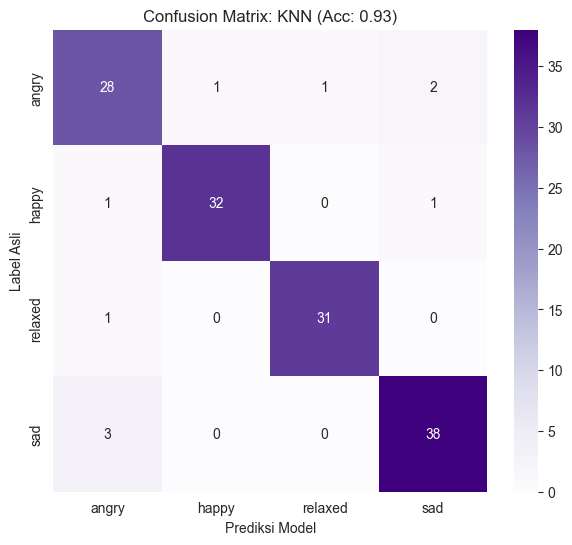

⚠️ KESALAHAN TERBESAR:
KNN sering salah mengira 'sad' sebagai 'angry' (3 kasus).


In [3]:
# --- EVALUASI KNN ---
print("\n" + "="*40)
print("📊 LAPORAN EVALUASI KNN")
print("="*40)

# 1. Classification Report
report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

# 2. Metrik Global
macro_f1 = f1_score(y_test, y_pred, average='macro')
macro_prec = precision_score(y_test, y_pred, average='macro')

print("-" * 40)
print(f"🏆 Macro F1-Score : {macro_f1:.4f}")
print(f"🎯 Macro Precision: {macro_prec:.4f}")
print("-" * 40)

# 3. Analisis Kesalahan (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', # <-- Warna Ungu Khas KNN
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix: KNN (Acc: {test_acc:.2f})')
plt.ylabel('Label Asli')
plt.xlabel('Prediksi Model')
plt.show()

# Cek Error Terbesar
np.fill_diagonal(cm, 0) 
max_error_idx = np.unravel_index(np.argmax(cm), cm.shape)
true_label_err = le.classes_[max_error_idx[0]]
pred_label_err = le.classes_[max_error_idx[1]]
count_err = cm[max_error_idx]

print(f"⚠️ KESALAHAN TERBESAR:")
print(f"KNN sering salah mengira '{true_label_err}' sebagai '{pred_label_err}' ({count_err} kasus).")